# COMP90051 Workshop 3
## Linear regression

***

Our aim for this part of the workshop is to fit a linear model from scratch—relying only on the `numpy` library. We'll experiment with analytic solution based on linear algebra first. Then, to check the correctness of our implementation, we'll compare its output to the output of `sklearn`.

Firstly we will import the relevant libraries (`numpy`, `matplotlib`, etc.).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

### 1. Review
In lectures, we saw that a linear model can be expressed as:
$$y(\mathbf{x}, \mathbf{w}) = w_0 + \sum_{j = 1}^{m} w_j x_j = \mathbf{w} \cdot \mathbf{x} $$
where 

* $y$ is the *target variable*;
* $\mathbf{x} = [x_1, \ldots, x_m]$ is a vector of *features* (we define $x_0 = 1$); and
* $\mathbf{w} = [w_0, \ldots, w_m]$ are the *weights*.

To acknowledge the uncertainty inherent in our model, we assume a _probabilistic model_ where the target variable $y$ is given by a deterministic function of the data/weights and additive Gaussian noise with zero mean and variance $\sigma^2$.

\begin{align}
    y &= \mathbf{w} \cdot \mathbf{x} + \epsilon \\
    \epsilon &\sim \mathcal{N}(0, \sigma^2)
\end{align}

This enables us to model the target variable as:

\begin{equation}
    p(y \vert \mathbf{x}) = \prod_k^n \mathcal{N}(y_k; \mathbf{w} \cdot \mathbf{x}, \sigma^2)
\end{equation}

We maximize the log-likelihood to choose parameter values maximizing the probability of the observed data. We saw in lectures that maximizing the log-likelihood is equivalent to _minimization_ of the following sum of squared residuals loss function.  

$$E(\mathbf{w}) = \sum_{i=1}^{n}(y_i - \mathbf{w} \cdot \mathbf{x}_i)^2$$

**Note:** For simplicity, we'll consider the case $m = 1$ (i.e. only one feature excluding the intercept).

### 2. Dataset

We'll work with the well-known _Boston Housing Dataset_ containing data about housing suburbs in Boston, Massachuetts. There are 13 features in this dataset which are intended to be used to predict the target, the median house value in the given suburb, `MEDV`. For simplicity we'll only work with a single variable, the percentage of the population in the suburb classified as 'lower status' by the US Census service in 1978, `LSTAT`. Plotting `LSTAT` vs. `MEDV` we see that a linear model appears plausible:

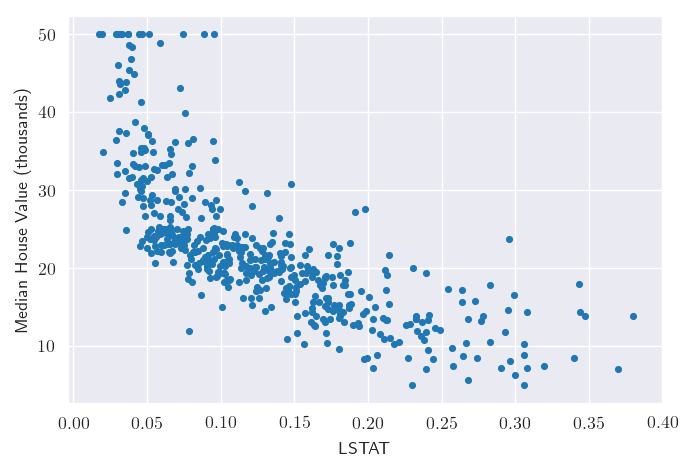

In [2]:
FIGURE_RESOLUTION = 128
plt.rcParams['figure.dpi'] = FIGURE_RESOLUTION

from sklearn.datasets import load_boston
boston = load_boston()
ds = pd.DataFrame(boston.data, columns=boston.feature_names)
features = ['LSTAT'] #  ds.columns  # ['RM', 'LSTAT']
target = 'MEDV'

ds['LSTAT'] = ds['LSTAT'].apply(lambda x: x/100.)

for f in features:
    plt.figure()
    plt.scatter(ds[f], boston.target, marker='.')
    plt.xlabel(f)
    plt.ylabel('Median House Value (thousands)')

In [3]:
Y = boston.target
from sklearn.model_selection import train_test_split
x_full_train, x_full_test, y_train, y_test = train_test_split(ds, Y, test_size=0.2, random_state=90051)
print("Training set has {} instances. Test set has {} instances.".format(x_full_train.shape[0], x_full_test.shape[0]))
x = x_full_train[features].values.ravel()
x_test = x_full_test[features].values.ravel()
y = y_train

Training set has 404 instances. Test set has 102 instances.


### 3. Linear algebra solution

In lectures, we saw that it's possible to solve for the optimal weights $\mathbf{w}^\star$ analytically by solving for $\nabla_{\mathbf{w}} E(\mathbf{w}) = 0$. This yields the _normal equations_ for the least squares problem:
$$\mathbf{w}^* = \left[\mathbf{X}^\top \mathbf{X}\right]^{-1} \mathbf{X}^\top \mathbf{y}$$
where $X$ is the _design matrix_. In our simple 1-feature case this is:

$$\mathbf{X} = \begin{pmatrix} 
        1 & x_1 \\ 1 & x_2 \\ \vdots & \vdots \\ 1 & x_n 
    \end{pmatrix} 
  \quad \text{and} \quad 
  \mathbf{y} = \begin{pmatrix} 
          y_1 \\ y_2 \\ \vdots \\ y_n
      \end{pmatrix}
$$

In [4]:
X = np.column_stack((np.ones_like(x), x))
X_test = np.column_stack((np.ones_like(x_test), x_test))
print('Design matrix shape:', X.shape)

Design matrix shape: (404, 2)


Although we can express $\mathbf{w}^\star$ explicitly in terms of the matrix inverse $(\mathbf{X}^\top \mathbf{X})^{-1}$, this isn't an efficient way to compute $\mathbf{w}$ numerically. It is better instead to solve the following system of linear equations:
$$\mathbf{X}^\top\mathbf{X} \mathbf{w}^\star = \mathbf{X}^\top\mathbf{y}$$

This can be done in numpy using the command `np.linalg.solve`. Enter `np.linalg.solve?` to see its docstring. Using this method gives:

In [5]:
w = np.linalg.solve(np.dot(X.T, X), np.dot(X.T, y))
print('Weights:', w)

Weights: [ 34.51530004 -95.80176887]


In [6]:
def predict(X_test, w): 
    return np.dot(X_test, w)  # fill in

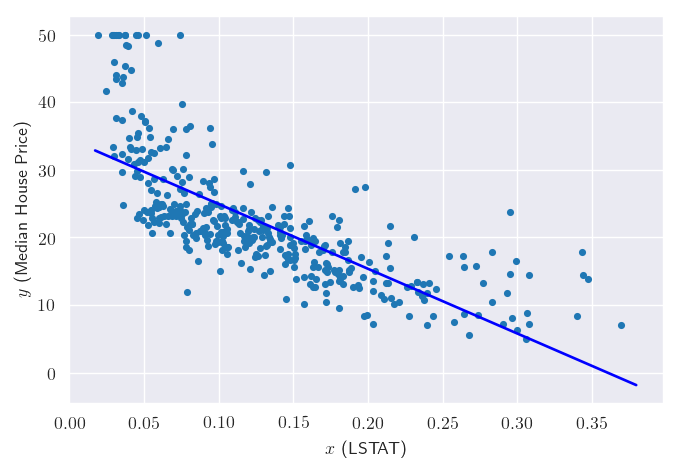

In [7]:
def plot_fit(x_test, y_test, x, y):
    
    # To get connecting lines in matplotlib correct
    sort_idx = np.argsort(x_test)
    y_test = y_test[sort_idx]
    x_test = np.sort(x_test)
    plt.plot(x_test, y_test, 'b-')
    plt.scatter(x, y, marker='.')
    plt.ylabel("$y$ (Median House Price)")
    plt.xlabel("$x$ (LSTAT)")
    plt.show()
    
plot_fit(x_test, predict(X_test, w), x, y)

We'll compute the mean error term over the training and test sets to assess model performance.

In [8]:
def mean_squared_error(X, w, y):
    return np.mean((np.dot(X, w) - y)**2)  # fill in

In [9]:
print('Train MSE:', mean_squared_error(X,w,y_train))
print('Test MSE:', mean_squared_error(X_test,w,y_test))

Train MSE: 38.6322164416081
Test MSE: 38.004204881013045


### 4. Solving using scikit-learn

Now that you have a good understanding of what's going on under the hood, you can use the functionality in `sklearn` to solve linear regression problems you encounter in the future. Using the `LinearRegression` module, fitting a linear regression model becomes a one-liner as shown below.

In [10]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(np.expand_dims(x,1), np.expand_dims(y,1))

The `LinearRegression` module provides access to the bias weight $w_0$ under the `intercept_` property

In [11]:
lr.intercept_

array([34.51530004])

and the non-bias weights under the `coef_` property

In [12]:
lr.coef_

array([[-95.80176887]])

You should check that these results match the solution you obtained previously. Note that sklearn also uses a numerical linear algebra solver under the hood.

Finally, what happens if we use the other 12 variables available in the dataset?

In [13]:
lr_full = LinearRegression().fit(x_full_train, y_train)
X_full = np.column_stack((np.ones(shape=x_full_train.shape[0]), x_full_train))
X_full_test = np.column_stack((np.ones(shape=x_full_test.shape[0]), x_full_test))
w_full = (lr_full.intercept_, *lr_full.coef_)
print('Full design matrix shape:', X_full.shape)

print('Train MSE:', mean_squared_error(X_full,w_full,y_train))
print('Test MSE:', mean_squared_error(X_full_test,w_full,y_test))

Full design matrix shape: (404, 14)
Train MSE: 20.063566279433815
Test MSE: 30.72530437501342


As measured by the MSE, our predictions are looking better. Although we obtained a performance boost here, in real problems you should be cautious of blindly including features in your analysis just because you can.

## 5. Introducing Nonlinear Basis Functions

While linear regression is extremely effective in the right context, the formulation above, where we model the target $y = \mathbf{w} \cdot \mathbf{x} + \epsilon, \; \epsilon \sim \mathcal{N}(0, \sigma^2)$ is a linear function in the variables $\mathbf{x}$, which may limit the expressiveness of our model. We can increase the flexibility of our model by introducing nonlinear basis functions of the input variables, $\vec{\phi}(\mathbf{x})$ in lieu of the original features $\mathbf{x}$. Now our predictor $y = \mathbf{w} \cdot \vec{\phi}(\mathbf{x})$ is a nonlinear function of the input $\mathbf{x}$ (but still linear in the model parameters $\mathbf{w}$). There are many possible choices for the basis $\vec{\phi}(\mathbf{x})$, but we will focus on using polynomial basis functions with the form $\phi(x) = x^j$ in the single-variable case. 

All our previous results for linear regression carry over as you would expect, we replace $\mathbf{w} \cdot \mathbf{x}$ with $\mathbf{w} \cdot \vec{\phi}(\mathbf{x})$ - the error function and normal equations become:

\begin{equation}
    E(\mathbf{w}) = \sum_{i=1}^{n}(y_i - \mathbf{w} \cdot \vec{\phi}(\mathbf{x}_i))^2
\end{equation}

\begin{equation}
    \mathbf{w}^* = \left[\mathbf{\Phi}^\top \mathbf{\Phi}\right]^{-1} \mathbf{\Phi}^\top \mathbf{y}
\end{equation}

Here the design matrix $\Phi \in \mathbb{R}^{n \times (m+1)}$ for $n$ datapoints and $m$ basis functions, $\vec{\phi}(\mathbf{x}) = (\phi_0(\mathbf{x}), \ldots \phi_m(\mathbf{x}))$. In the case of polynomial regression $\vec{\phi}(x) = \left(1,x,x^2,\ldots, x^m\right)$ (note the one additional bias parameter). For example, for a maximum polynomial order of 3, the design matrix is:

$$
\mathbf{\Phi} = \begin{pmatrix} 
        1 & x_1 & x_1^2 & x_1^3 \\ 1 & x_2 & x_2^2 & x_2^3 \\ \vdots & \vdots & \vdots & \vdots \\ 1 & x_n & x_n^2 & x_n^3
\end{pmatrix}
$$

We'll start by building the design matrix.

In [14]:
def design_matrix_poly(x, x_test, order, silent=True):
    """
    Returns design matrix on training and testing data
    for polynomial basis of specified order
    """
    n, n_test, m = x.shape[0], x_test.shape[0], order + 1
    Phi = np.zeros([n,m])
    Phi_test = np.zeros([n_test,m])

    for k in range(order+1):
        Phi[:,k] = np.power(x, k)
        Phi_test[:,k] = np.power(x_test,k)

    if silent is False:
        print('Design matrix shape (training):', Phi.shape)
    
    return Phi, Phi_test

In [15]:
start_order = 3
Phi, Phi_test = design_matrix_poly(x, x_test, order=start_order, silent=False)

Design matrix shape (training): (404, 4)


Now let's solve the linear system using the inbuilt `numpy` routine and plot the result of the predicted values on the training set. 

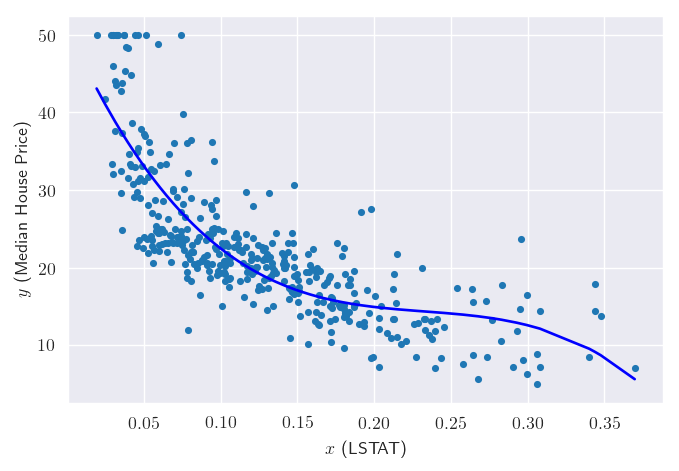

In [16]:
w_poly = np.linalg.solve(np.dot(Phi.T, Phi), np.dot(Phi.T, y))
plot_fit(x, predict(Phi, w_poly), x, y)
# plot_fit(x_test, predict(Phi_test, w_poly), x, y)

Seems like a better fit than the linear model! Let's take a look at the error terms on the train/test set:

In [17]:
print('Train MSE for polynomial features of order {}: {:.3f}'.format(start_order, mean_squared_error(Phi, w_poly, y_train)))
print('Test MSE for polynomial features of order {}: {:.3f}'.format(start_order, mean_squared_error(Phi_test, w_poly, y_test)))

print('Train MSE using linear features only: {:.3f}'.format(mean_squared_error(X, w, y_train)))
print('Test MSE using linear features only: {:.3f}'.format(mean_squared_error(X_test, w, y_test)))

Train MSE for polynomial features of order 3: 27.391
Test MSE for polynomial features of order 3: 35.628
Train MSE using linear features only: 38.632
Test MSE using linear features only: 38.004


Strange, a large reduction on the train MSE but not so much on the test MSE. Lets scan across a range of powers. What do you expect to happen as we increase the maximum polynomial order on the training set? Take a minute to discuss with your fellow students before executing the next cell.

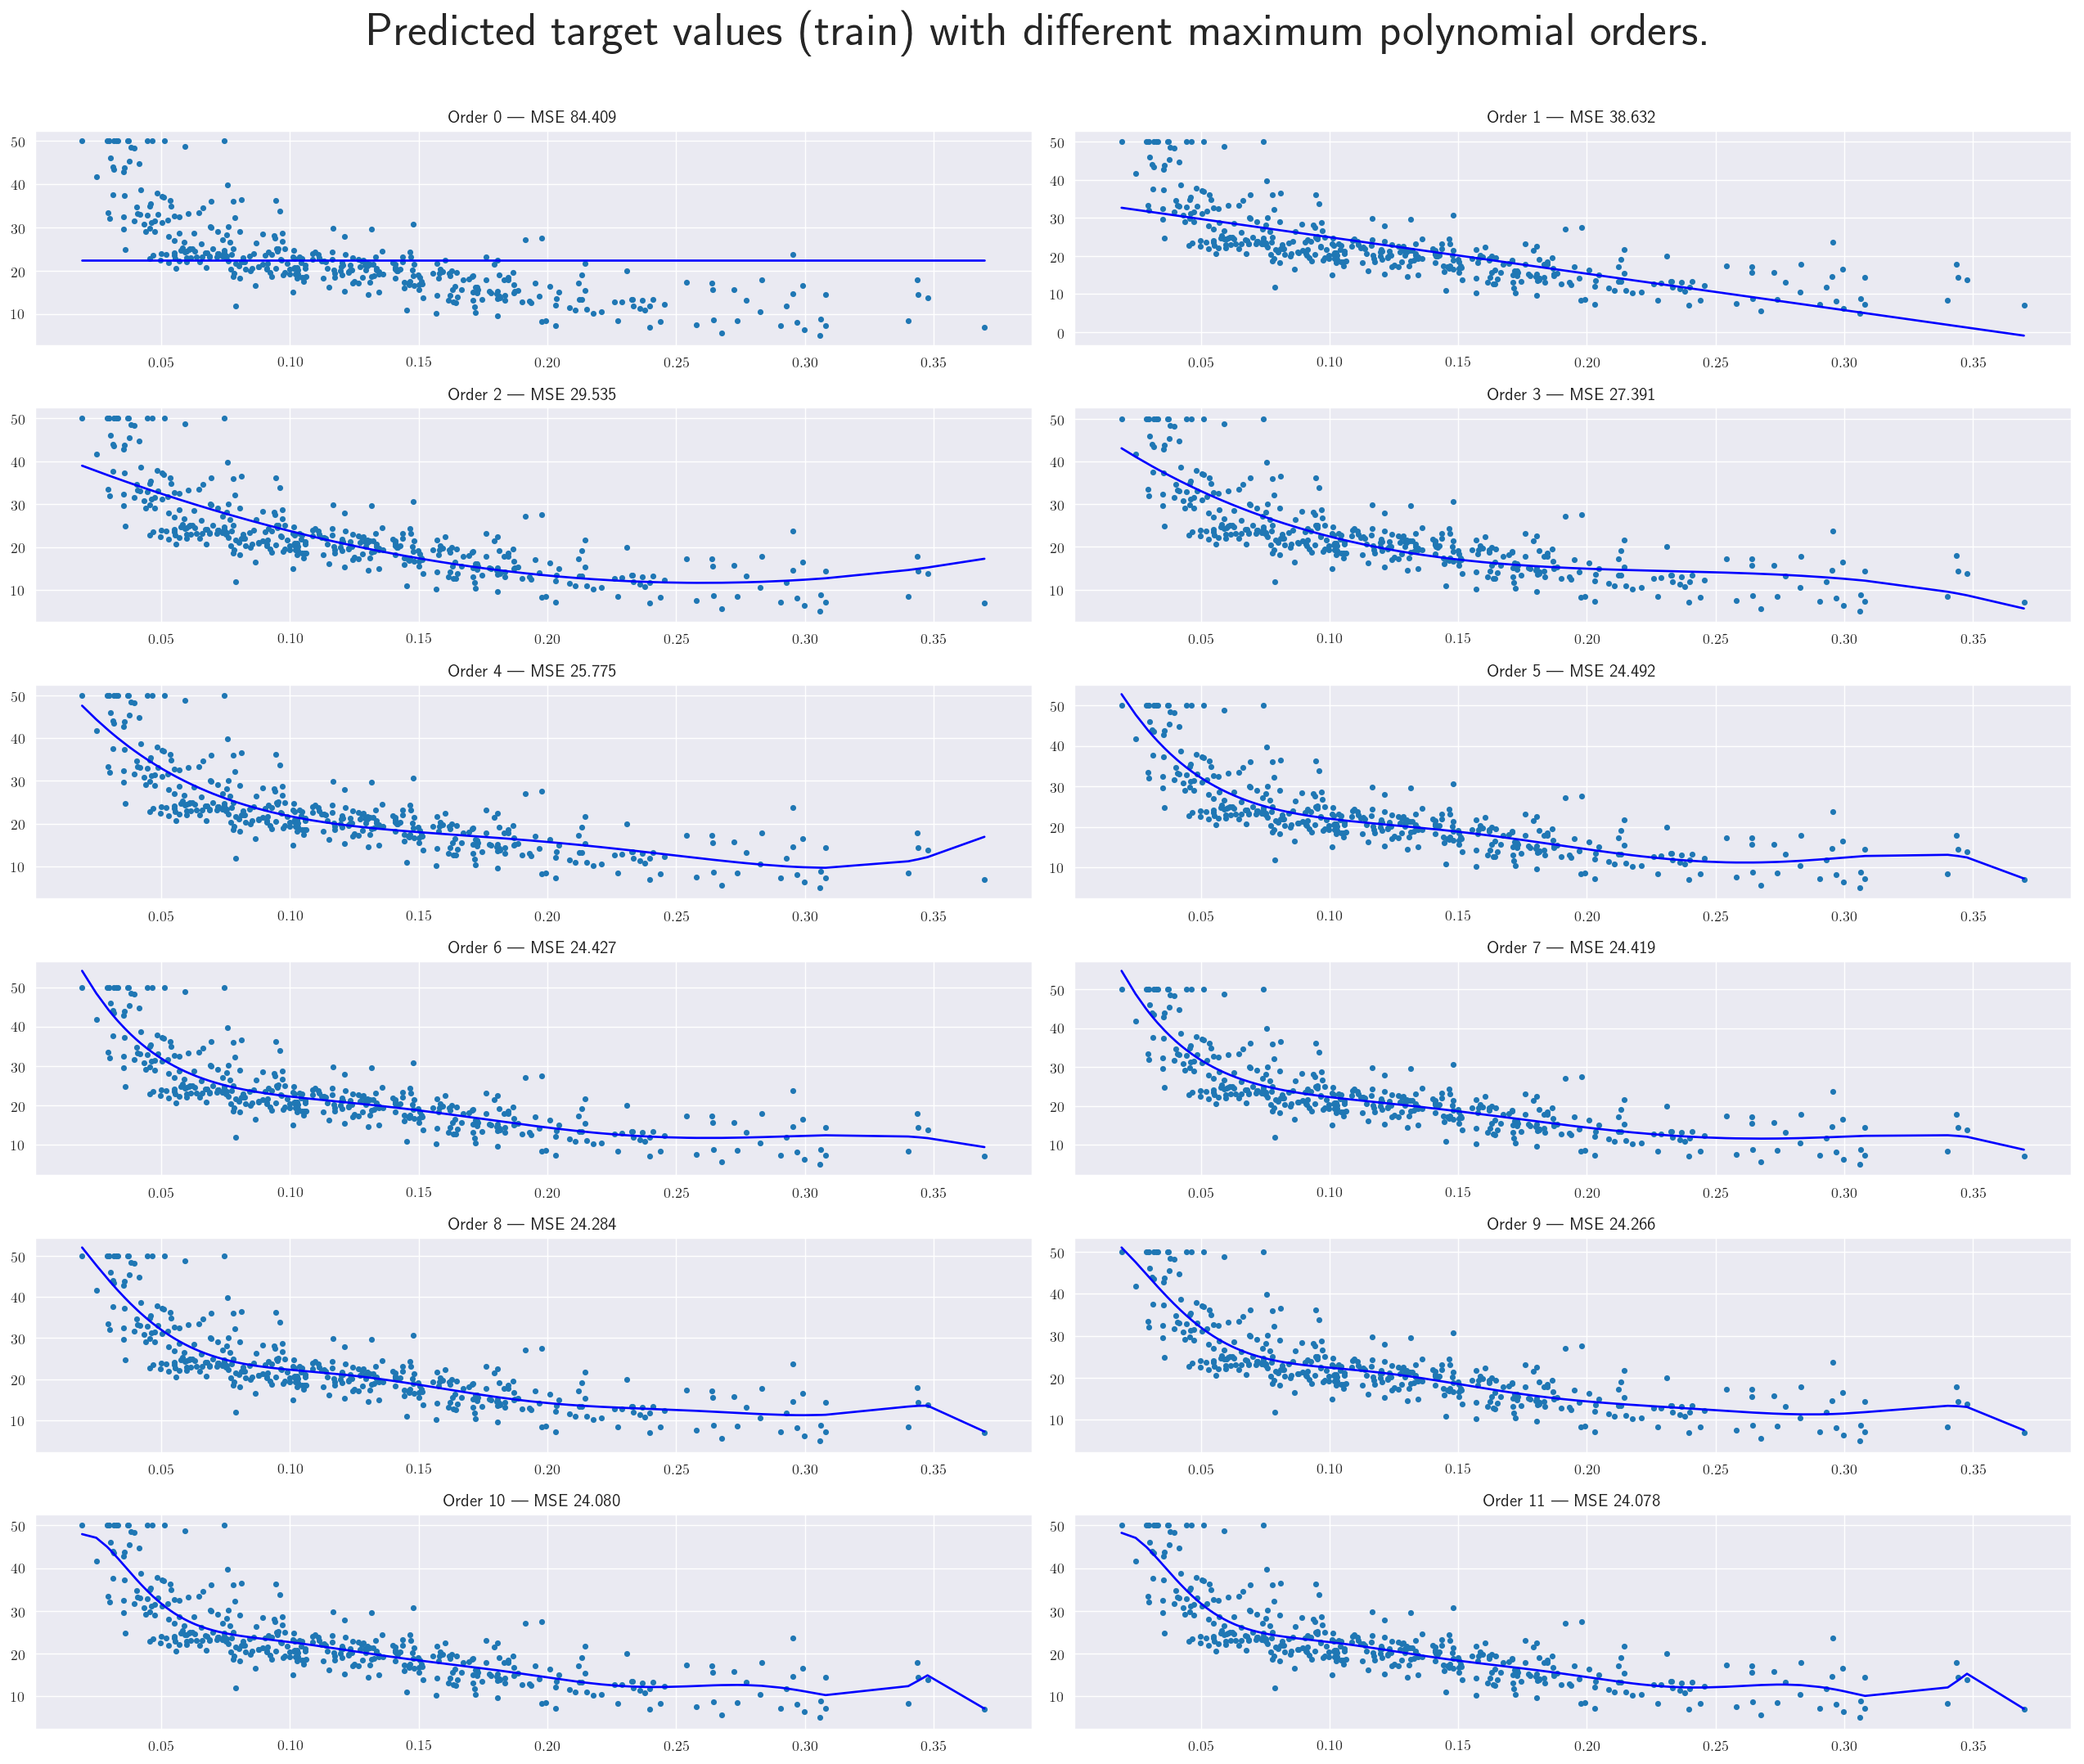

In [18]:
orders = list(range(12))
Phi_test_orders = list()
w_orders = list()
mse_orders = list()

sort_idx = np.argsort(x)
y_plot = y[sort_idx]
x_plot = np.sort(x)

plt.figure(figsize=(20,16))
for i, order in enumerate(orders):
    sub = plt.subplot(len(orders)//2, 2, i+1)    
    Phi, Phi_test = design_matrix_poly(x, x_test, order=order)
    w_poly = np.linalg.solve(np.dot(Phi.T, Phi), np.dot(Phi.T, y))
    mse = mean_squared_error(Phi, w_poly, y)

    Phi_test_orders.append(Phi_test)
    w_orders.append(w_poly)
    mse_orders.append(mse)
    
    plt.plot(x_plot, predict(Phi, w_poly)[sort_idx], 'b-')
    plt.scatter(x_plot, y_plot, marker='.')
    plt.title('Order {} | MSE {:.3f}'.format(order, mse))
    plt.autoscale()
    
plt.suptitle('Predicted target values (train) with different maximum polynomial orders.', y=1.05, fontsize=32)
plt.tight_layout()

Now we'll repeat on the test set.

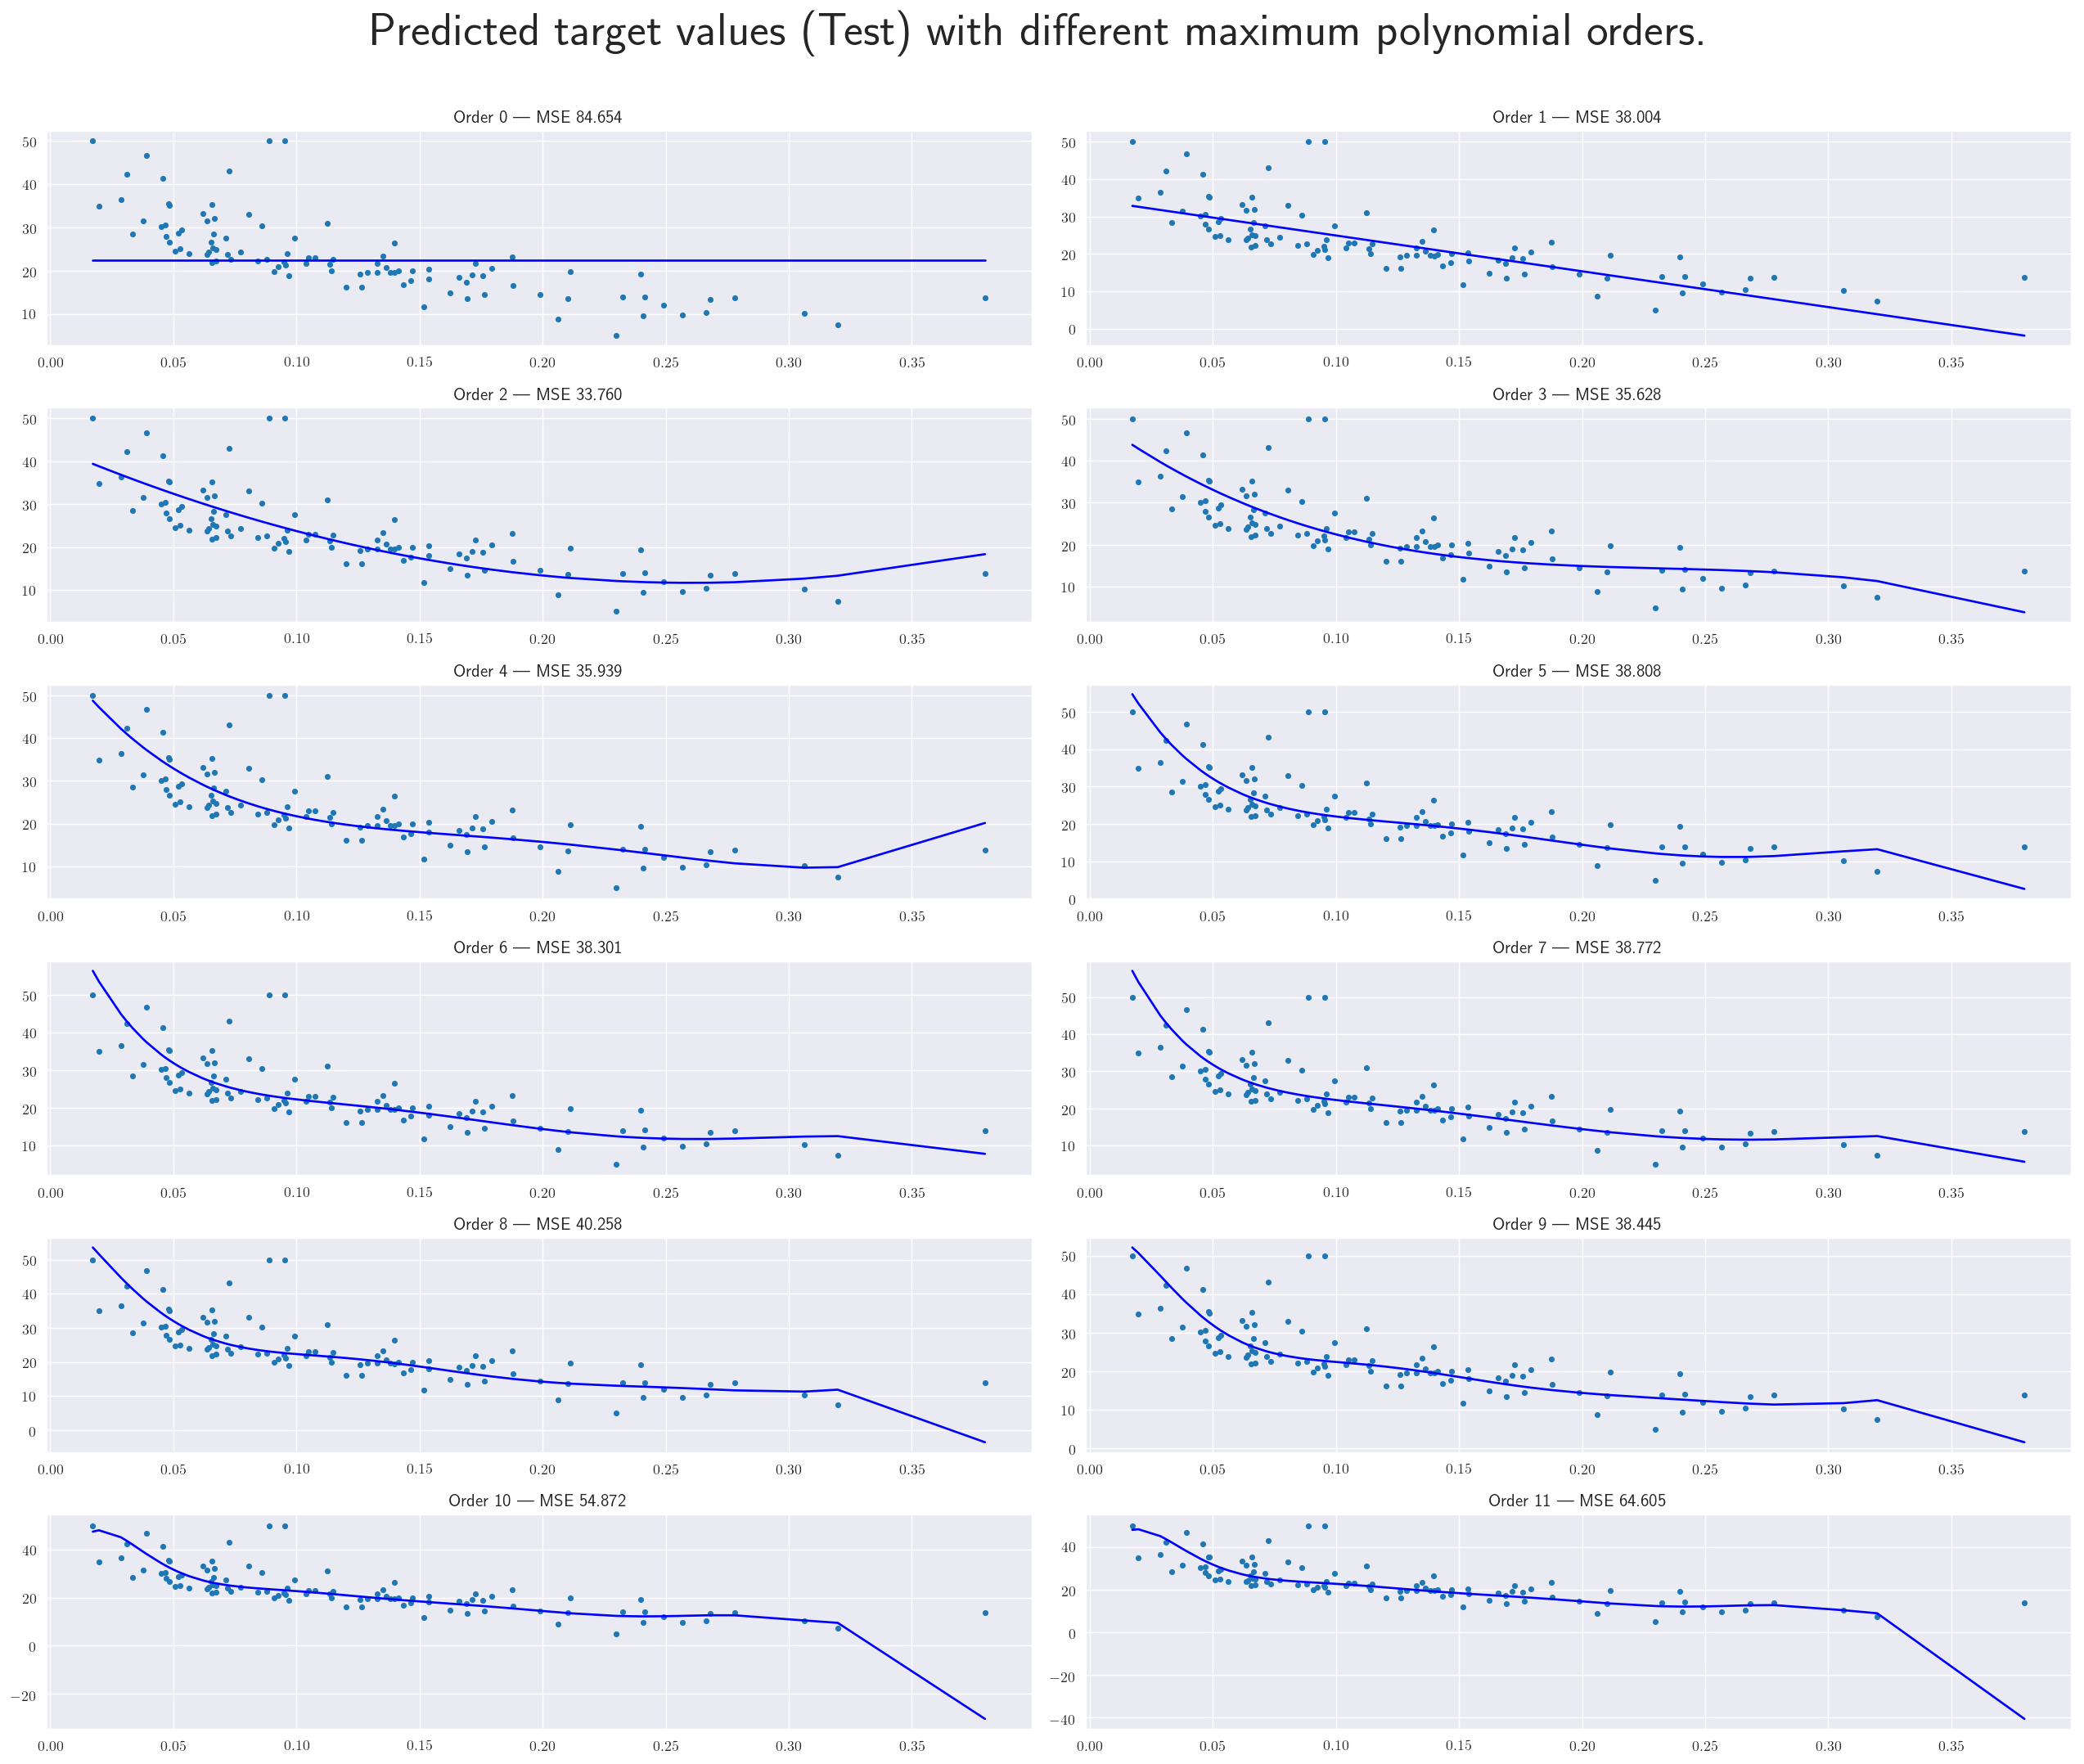

In [19]:
mse_test_orders = list()
sort_idx = np.argsort(x_test)
y_plot = y_test[sort_idx]
x_plot = np.sort(x_test)

plt.figure(figsize=(20,16))
for i, order in enumerate(orders):
    sub = plt.subplot(len(orders)//2, 2, i+1)    
    Phi_test = Phi_test_orders[i]
    w_poly = w_orders[i]
    
    mse_test = mean_squared_error(Phi_test, w_poly, y_test)
    mse_test_orders.append(mse_test)
    

    plt.plot(x_plot, predict(Phi_test, w_poly)[sort_idx], 'b-')
    plt.scatter(x_plot, y_plot, marker='.')
    plt.title('Order {} | MSE {:.3f}'.format(order, mse_test))
    plt.autoscale()
    
plt.suptitle('Predicted target values (Test) with different maximum polynomial orders.', y=1.05, fontsize=32)
plt.tight_layout()

Let's plot MSE vs. polynomial order for the train and held-out datasets.

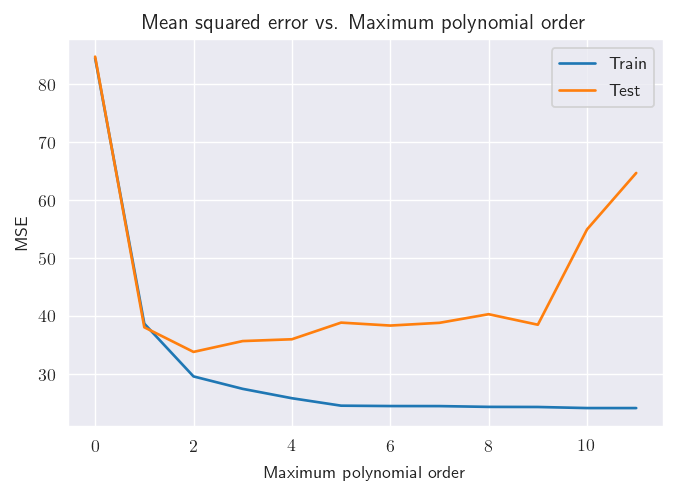

In [20]:
plt.plot(range(len(mse_orders)), mse_orders, label='Train')
plt.plot(range(len(mse_test_orders)), mse_test_orders, label='Test')
plt.title('Mean squared error vs. Maximum polynomial order')
plt.ylabel('MSE')
plt.xlabel('Maximum polynomial order')
plt.legend()

**Discussion**: 🤨 What is going on here? Does this match your earlier findings, or your intuition about which model order was most appropriate? Why isn't held-out error behaving the same as training error?

In principle increasing the polynomial order should increase the 'hypothesis space' of the model. However the MSE on the test set appears to rise with increasing polynomial order past 2. The results we covered above should make you uneasy about increasing model capacity without careful thought. Fortunately Lecture 5 on 'Regularization' and next week's workbook should assuage your concerns.

## Bonus: Kernel Ridge Regression
This section is optional: we are unlikely to have time for it.

Several (theoretically well-motivated) approaches suggest minimizing a tradeoff between the empirical squared loss and the $L_2$ norm of the weight vector, or equivalently the norm squared. Kernel ridge regression is defined by minimization of an objective function with the form:

\begin{equation}
    E(\mathbf{w}) = \sum_{i=1}^{n}(y_i - \mathbf{w} \cdot \vec{\phi}(\mathbf{x}_i))^2 + \frac{\lambda}{2} \vert \vert \mathbf{w} \vert \vert^2
\end{equation}

Once again we set $\nabla_{\mathbf{w}} E(\mathbf{w}) = 0$ to find the global minimum of the error function. Proceeding as before, we obtain the solution

\begin{equation}
    \mathbf{w}^* = \left(\mathbf{\Phi}^\top \mathbf{\Phi} + \lambda \mathbb{1}\right)^{-1} \mathbf{\Phi}^\top \mathbf{y}
\end{equation} 

The matrix $\mathbf{\Phi}^\top \mathbf{\Phi} + \lambda \mathbb{1}$ is always invertible (why?), so ridge regression has a closed-form solution. We'll generate the same plots as above but including this L2 weight penalty term using $\lambda = 0.001$.

**Proof of claim above:** $\mathbf{\Phi}^T\mathbf{\Phi}$ is a positive semi-definite (PSD) matrix. This means that all eigenvalues are non-negative, to see this, consider the PSD condition for a matrix $A$: 

$$ \mathbf{x}^T A \mathbf{x} \geq 0 \; \forall \; \mathbf{x} \in \mathbb{R}^n $$

Now let $\mathbf{x}$ be an eigenvector of $A$ with eigenvalue $\mu$, then 

\begin{align}
    \mathbf{x}^T A \mathbf{x} &\geq 0 \\
    &= \mu  \mathbf{x}^T \mathbf{x} \\
    &= \mu \vert \mathbf{x} \vert^2
\end{align}

Since $\vert \mathbf{x} \vert^2 \geq 0$, we must have $\mu > 0$. Note that thanks to the spectral theorem, any PSD matrix is also diagonalizable with real eigenvalues.

Now remember how we find determinants 'by-hand', let $\Lambda$ be an arbitrary eigenvalue of the matrix $\mathbf{\Phi}^\top \mathbf{\Phi} + \lambda \mathbb{1}$. Remember now $\lambda > 0$ is overloaded as the coefficient of the L2 regularization term.

\begin{align}
    \det\left(\mathbf{\Phi}^T\mathbf{\Phi} + \lambda \mathbb{1} - \Lambda \mathbb{1}\right) &= 0 \\
    &= \det\left(\mathbf{\Phi}^T \mathbf{\Phi} - (\Lambda - \lambda)\mathbb{1}\right) 
\end{align}

So now we have $\Lambda - \lambda  = \mu \rightarrow \Lambda = \mu + \lambda > 0$. Thus the eigenvalues of $\mathbf{\Phi}^\top \mathbf{\Phi} + \lambda \mathbb{1}$ are the sum of the non-negative eigenvalues of the PSD matrix $\mathbf{\Phi}^\top \mathbf{\Phi}$ and $\lambda > 0$. So kernel ridge regression admits a closed form solution. Practically, we are 'adding $\lambda$' to the eigenvalues of the original PSD matrix  $\mathbf{\Phi}^\top \mathbf{\Phi}$ - now the matrix to be inverted is guaranteed to be nonsingular and a small variation in the data does not cause instability in the matrix inversion anymore, even if there exist any eigenvalues $\Lambda$ close to zero. 

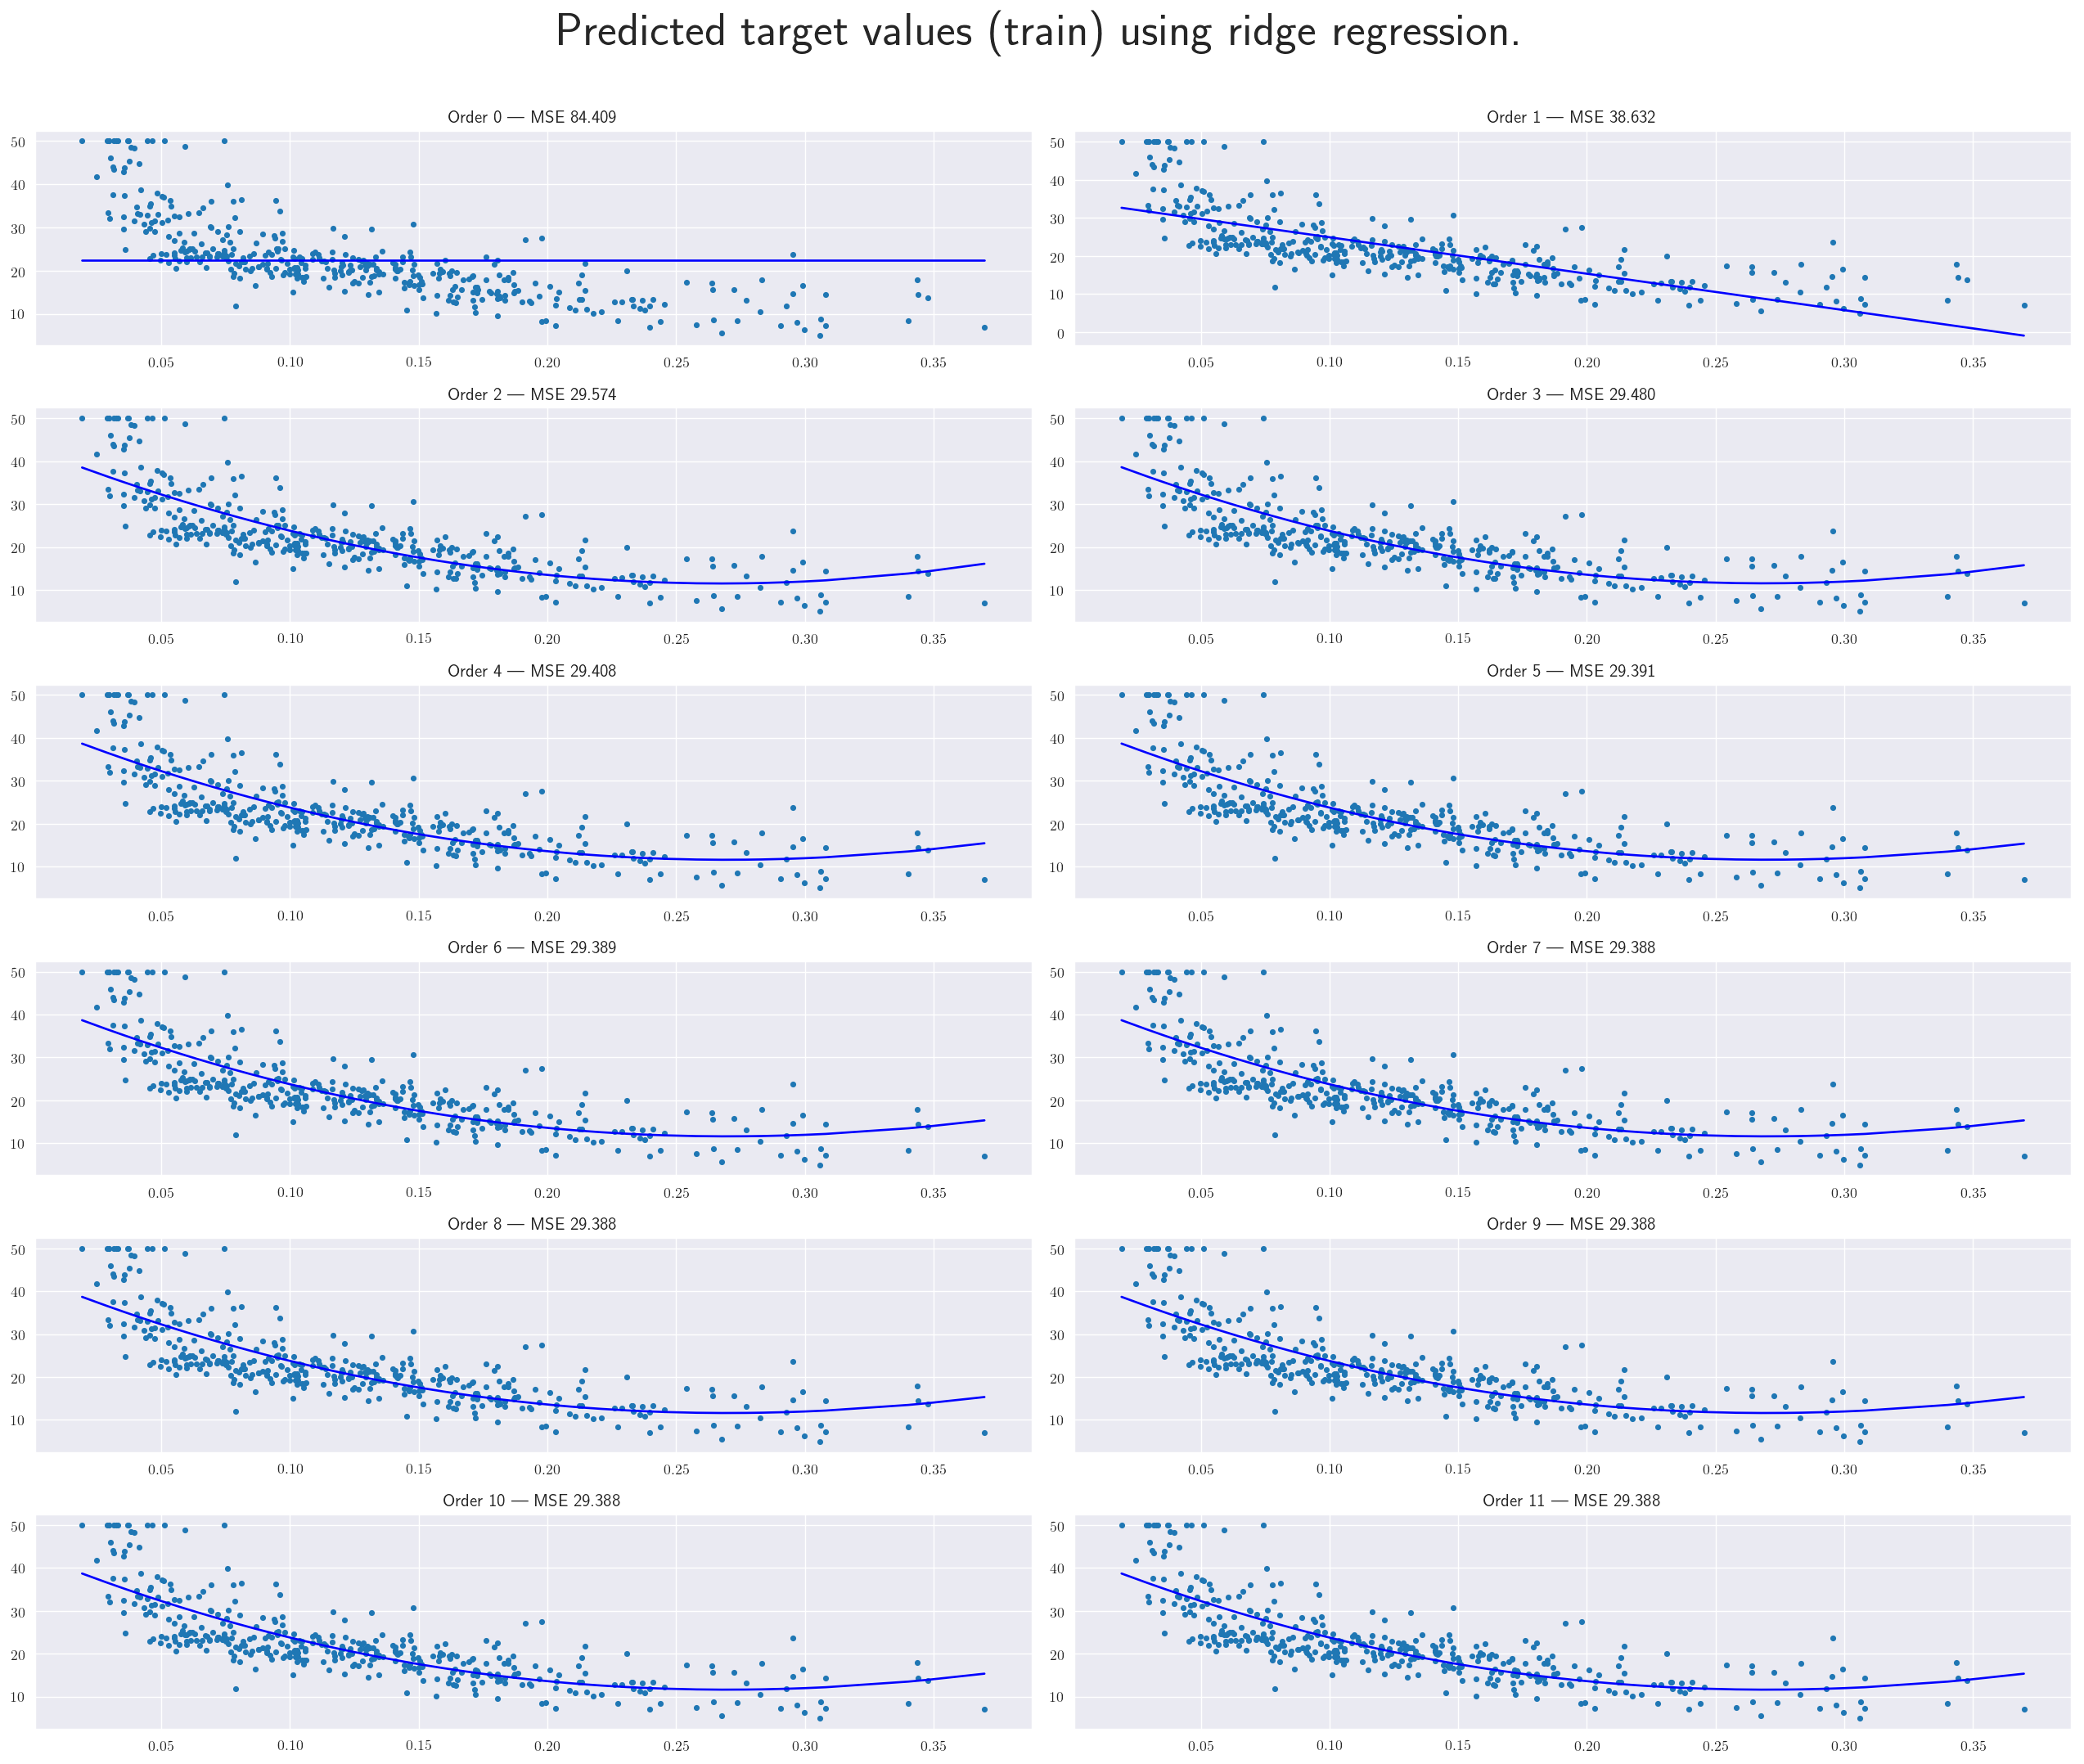

In [21]:
orders = list(range(12))
Phi_test_orders = list()
w_orders = list()
mse_orders = list()

sort_idx = np.argsort(x)
y_plot = y[sort_idx]
x_plot = np.sort(x)

lambda_RR = 0.001

plt.figure(figsize=(20,16))
for i, order in enumerate(orders):
    sub = plt.subplot(len(orders)//2, 2, i+1)    
    Phi, Phi_test = design_matrix_poly(x, x_test, order=order)
    w_poly = np.linalg.solve(np.dot(Phi.T, Phi) + lambda_RR * np.eye(order+1) , np.dot(Phi.T, y))
    mse = mean_squared_error(Phi, w_poly, y)

    Phi_test_orders.append(Phi_test)
    w_orders.append(w_poly)
    mse_orders.append(mse)
    
    plt.plot(x_plot, predict(Phi, w_poly)[sort_idx], 'b-')
    plt.scatter(x_plot, y_plot, marker='.')
    plt.title('Order {} | MSE {:.3f}'.format(order, mse))
    plt.autoscale()
    
plt.suptitle('Predicted target values (train) using ridge regression.', y=1.05, fontsize=32)
plt.tight_layout()

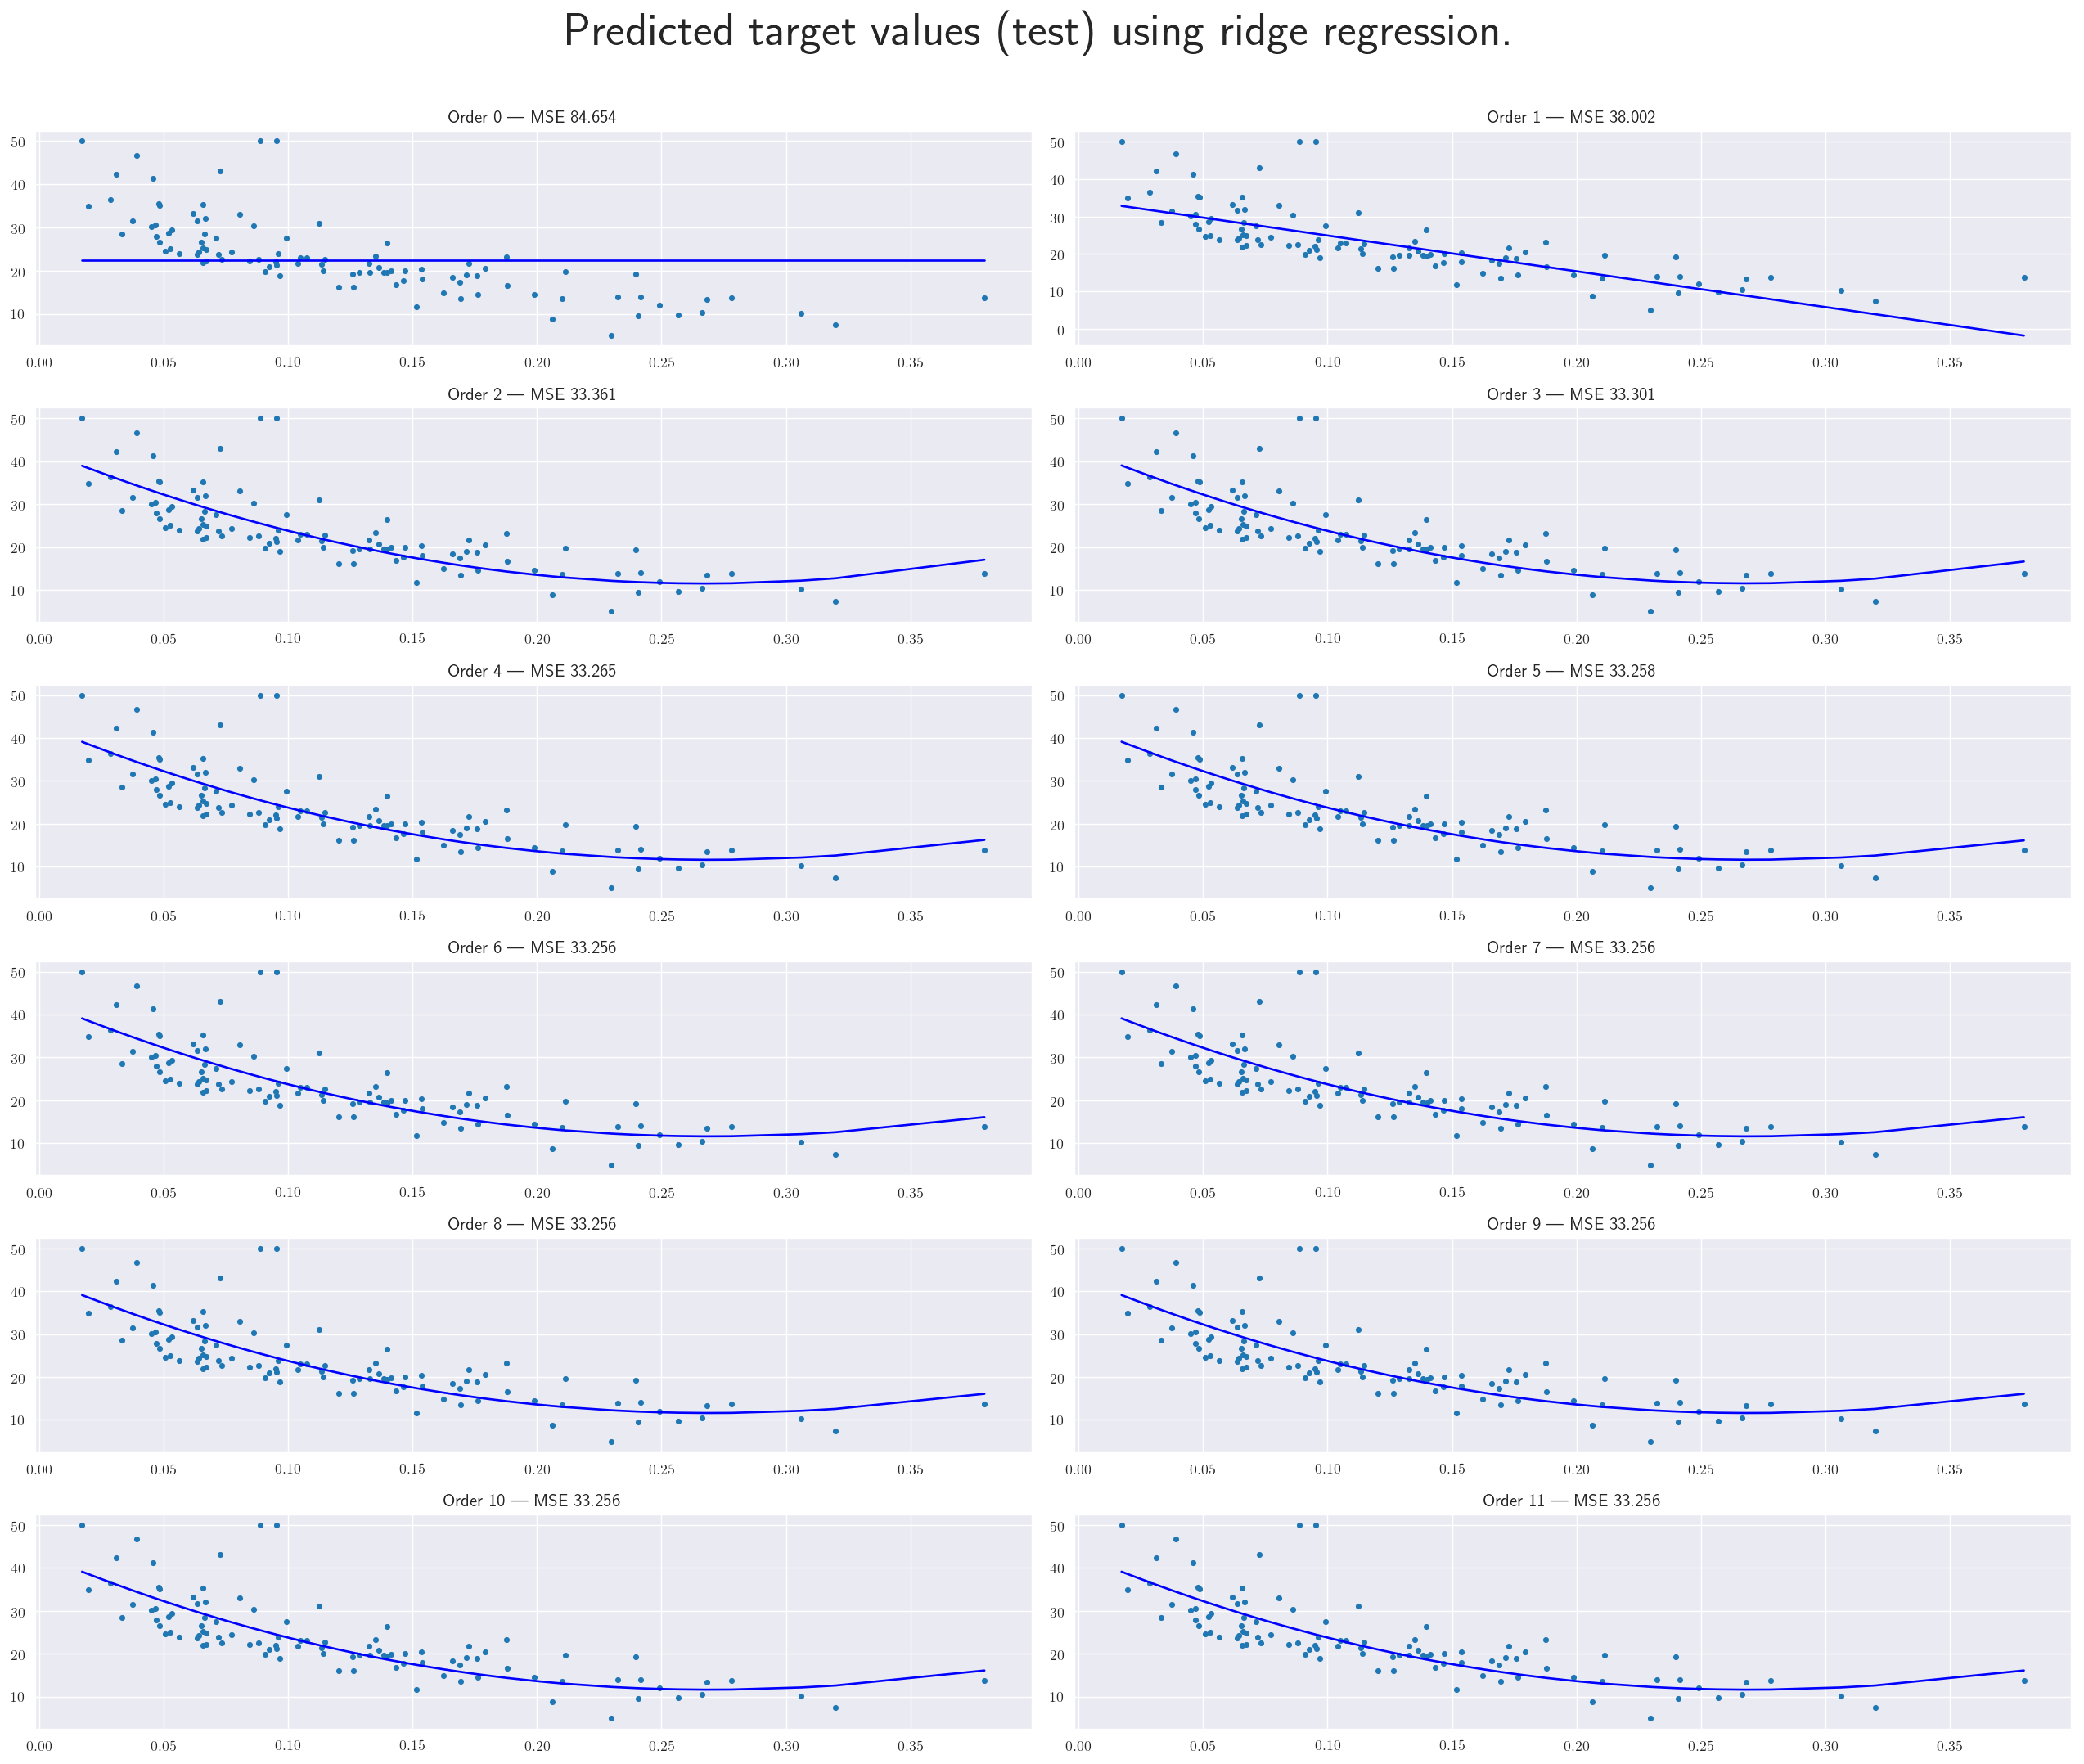

In [22]:
mse_test_orders = list()
sort_idx = np.argsort(x_test)
y_plot = y_test[sort_idx]
x_plot = np.sort(x_test)

plt.figure(figsize=(20,16))
for i, order in enumerate(orders):
    sub = plt.subplot(len(orders)//2, 2, i+1)    
    Phi_test = Phi_test_orders[i]
    w_poly = w_orders[i]
    
    mse_test = mean_squared_error(Phi_test, w_poly, y_test)
    mse_test_orders.append(mse_test)
    

    plt.plot(x_plot, predict(Phi_test, w_poly)[sort_idx], 'b-')
    plt.scatter(x_plot, y_plot, marker='.')
    plt.title('Order {} | MSE {:.3f}'.format(order, mse_test))
    plt.autoscale()
    
plt.suptitle('Predicted target values (test) using ridge regression.', y=1.05, fontsize=32)
plt.tight_layout()

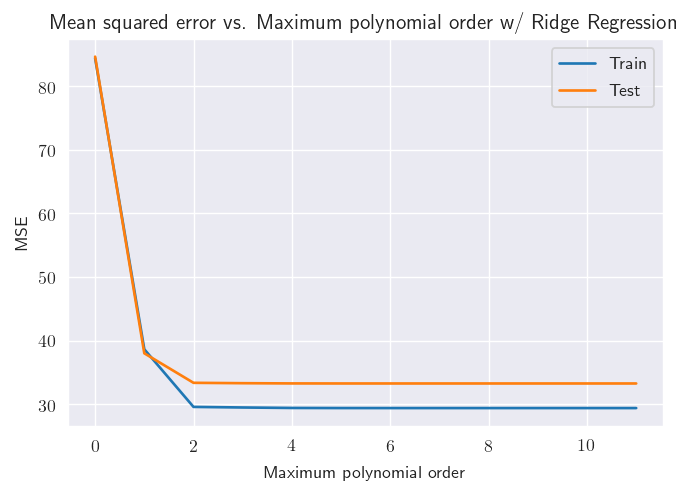

In [23]:
plt.plot(range(len(mse_orders)), mse_orders, label='Train')
plt.plot(range(len(mse_test_orders)), mse_test_orders, label='Test')
plt.title('Mean squared error vs. Maximum polynomial order w/ Ridge Regression')
plt.ylabel('MSE')
plt.xlabel('Maximum polynomial order')
plt.legend()

Finally, we'll plot the L2 norm of the found weights versus max. polynomial order. You should compare this with the non-regularized values!

Text(0,0.5,'$\\vert \\vert \\mathbf{w} \\vert \\vert^2$')

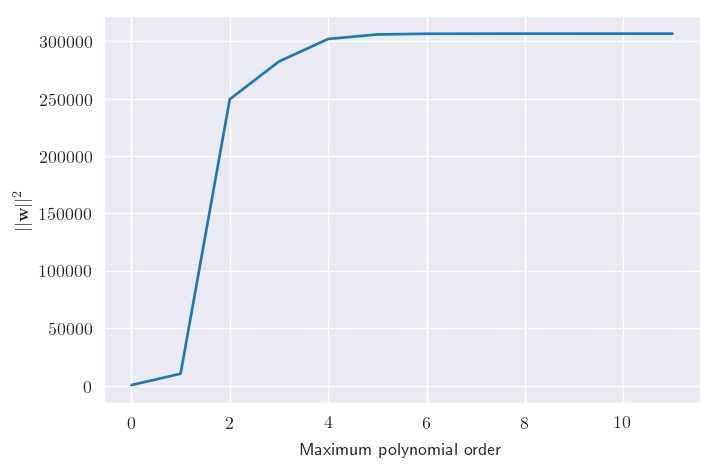

In [24]:
w_L2 = [np.sum(w**2) for w in w_orders]
plt.plot(range(len(w_L2)), w_L2)
plt.xlabel('Maximum polynomial order')
plt.ylabel(r'$\vert \vert \mathbf{w} \vert \vert^2$')



**Discussion:** You may want to experiment with different settings for $\lambda$. How would one select the 'best' value of $\lambda$ to balance between good train performance and generalization?
